### Experiment 2 

In [3]:
import timm
import time 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets 
from torch.utils.data import DataLoader
# from medmnist import INFO
import numpy as np
import faiss
import copy
from tqdm import tqdm

from torch.nn.functional import softmax, cosine_similarity
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import os 

import warnings
warnings.filterwarnings("ignore")

In [4]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda:1


In [5]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image

class CustomImageListDataset(torch.utils.data.Dataset):
    def __init__(self, file_list, class_to_idx, transform=None):
        with open(file_list, "r") as f:
            self.samples = [line.strip() for line in f]
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path = self.samples[idx]
        class_folder = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx.get(class_folder, -1)
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, label


# ---------------- Create a combined class mapping ----------------
root_dir = "dataset/imagenet_tests"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Collect class mappings from all 10 partitions
combined_class_to_idx = {}
for i in range(1, 11):
    test_dir = os.path.join(root_dir, f"test{i}")
    dataset = datasets.ImageFolder(test_dir, transform=transform)
    combined_class_to_idx.update(dataset.class_to_idx)

print(f"✅ Combined class mapping built: {len(combined_class_to_idx)} total classes")

# ---------------- Load your 1000-image subset ----------------
subset_file = "results/hard_cases_missed_by_mobilenet.txt"
hard_dataset = CustomImageListDataset(subset_file, class_to_idx=combined_class_to_idx, transform=transform)
hard_loader = DataLoader(hard_dataset, batch_size=1, shuffle=False)

print(f"✅ Loaded {len(hard_dataset)} hard samples")

✅ Combined class mapping built: 1000 total classes
✅ Loaded 1000 hard samples


In [6]:
def get_models(dataset, model_name, key): 
    if dataset == 'imagenet':
        # save_root_path = r"checkpoint/tinyimagenet"
        model = timm.create_model(model_name, pretrained=True, num_classes=1000).to(device)
        model.eval()
        if 'inc' in key or 'vit' in key or 'bit' in key:
            return torch.nn.Sequential(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), model)
        else:
            return torch.nn.Sequential(transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), model)

### Ensemble Attack 

In [7]:
import torch
import torch.nn.functional as F
from typing import List

def ensemble_mi_fgsm(
    models: List[torch.nn.Module],
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float = 8/255,
    alpha: float = 2/255,
    iters: int = 10,
    decay: float = 1.0,
    clip_min: float = 0.0,
    clip_max: float = 1.0,
    loss_fn=None,
    device: str = None,
):
    if device is None:
        device = x.device

    if not isinstance(models, (list, tuple)):
        models = [models]

    for m in models:
        m.to(device).eval()

    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

    x_orig = x.clone().detach().to(device).float()
    x_adv = x_orig.clone().detach()
    momentum = torch.zeros_like(x_adv).to(device)
    y = y.to(device)

    for _ in range(iters):
        x_adv.requires_grad_(True)

        # ----- Liu et al. (2017): sum/average logits before loss -----
        sum_logits = None
        for m in models:
            out = m(x_adv)
            if isinstance(out, (tuple, list)):
                out = out[0]
            sum_logits = out if sum_logits is None else sum_logits + out
        avg_logits = sum_logits / len(models)
        total_loss = loss_fn(avg_logits, y)
        # --------------------------------------------------------------

        grad = torch.autograd.grad(total_loss, x_adv, retain_graph=False, create_graph=False)[0]
        grad = grad / (torch.norm(grad, p=1) + 1e-8)

        # momentum update (MI-FGSM)
        momentum = decay * momentum + grad
        step = alpha * momentum.sign()

        x_adv = x_adv.detach() + step.detach()
        delta = torch.clamp(x_adv - x_orig, min=-eps, max=eps)
        x_adv = torch.clamp(x_orig + delta, min=clip_min, max=clip_max).detach()

    return x_adv


In [8]:
import torch
import torch.nn.functional as F
from typing import List

def ensemble_pgd(
    models: List[torch.nn.Module],
    x: torch.Tensor,
    y: torch.Tensor,
    eps: float = 8/255,
    alpha: float = 2/255,
    iters: int = 10,
    clip_min: float = 0.0,
    clip_max: float = 1.0,
    loss_fn=None,
    device: str = None,
    random_start: bool = False,
):
    """
    Ensemble PGD (average-logits) — same ensemble formulation as your MI-FGSM function
    but using PGD (no momentum).
    - models: list of models (or single model)
    - random_start: if True, initialize x_adv with a random perturbation within the eps-ball
    """
    if device is None:
        device = x.device

    if not isinstance(models, (list, tuple)):
        models = [models]

    for m in models:
        m.to(device).eval()

    if loss_fn is None:
        loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')

    x_orig = x.clone().detach().to(device).float()

    # optionally random start inside the L-inf ball
    if random_start:
        x_adv = x_orig + torch.empty_like(x_orig).uniform_(-eps, eps)
        x_adv = torch.clamp(x_adv, min=clip_min, max=clip_max).detach()
    else:
        x_adv = x_orig.clone().detach()

    y = y.to(device)

    for _ in range(iters):
        x_adv.requires_grad_(True)

        # ----- Liu et al. (2017): sum/average logits before loss -----
        sum_logits = None
        for m in models:
            out = m(x_adv)
            if isinstance(out, (tuple, list)):
                out = out[0]
            sum_logits = out if sum_logits is None else sum_logits + out
        avg_logits = sum_logits / len(models)
        total_loss = loss_fn(avg_logits, y)
        # --------------------------------------------------------------

        grad = torch.autograd.grad(total_loss, x_adv, retain_graph=False, create_graph=False)[0]
        # normalize (L1) like in your MI-FGSM code
        grad = grad / (torch.norm(grad, p=1) + 1e-8)

        # PGD step (no momentum) — use sign to match typical PGD / I-FGSM
        step = alpha * grad.sign()
        x_adv = x_adv.detach() + step.detach()

        # project back to epsilon L-inf ball around original and clip to valid range
        delta = torch.clamp(x_adv - x_orig, min=-eps, max=eps)
        x_adv = torch.clamp(x_orig + delta, min=clip_min, max=clip_max).detach()

    return x_adv

In [9]:
import torch
import torch.nn.functional as F
from torch import nn
from typing import List, Union, Optional

def get_gaussian_kernel(kernel_size: int = 15, sigma: float = 3.0, channels: int = 3, device='cpu'):
    ax = torch.arange(-(kernel_size // 2), kernel_size // 2 + 1, device=device, dtype=torch.float32)
    xx, yy = torch.meshgrid(ax, ax, indexing='xy')
    kernel = torch.exp(-(xx**2 + yy**2) / (2.0 * sigma**2))
    kernel = kernel / kernel.sum()
    kernel = kernel.view(1, 1, kernel_size, kernel_size)
    kernel = kernel.repeat(channels, 1, 1, 1)  # grouped conv
    return kernel

def diverse_input(x: torch.Tensor, prob: float = 0.7, resize_min: int = 290, resize_max: int = 330):
    """
    Random resize + pad/crop. Works on x of shape (B,C,H,W).
    If probability check fails, returns x unchanged.
    """
    if prob <= 0 or torch.rand(1).item() > prob:
        return x
    B, C, H, W = x.shape
    # choose a random size (square)
    size = int(torch.randint(resize_min, resize_max + 1, (1,)).item())
    x_resized = F.interpolate(x, size=(size, size), mode='bilinear', align_corners=False)
    pad_h = max(0, H - size)
    pad_w = max(0, W - size)
    pad_top = int(torch.randint(0, pad_h + 1, (1,)).item()) if pad_h > 0 else 0
    pad_left = int(torch.randint(0, pad_w + 1, (1,)).item()) if pad_w > 0 else 0
    pad_bottom = pad_h - pad_top
    pad_right = pad_w - pad_left
    x_padded = F.pad(x_resized, (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0.0)
    # if resized is bigger than original, center crop
    if size > H:
        start_h = (size - H) // 2
        start_w = (size - W) // 2
        x_padded = x_padded[:, :, start_h:start_h+H, start_w:start_w+W]
    return x_padded

def ensemble_ti_dim_mi_fgsm(
    models: Union[nn.Module, List[nn.Module]],
    images: torch.Tensor,
    labels: torch.Tensor,
    eps: float = 8/255,
    iters: int = 10,
    alpha: Optional[float] = None,
    decay: float = 1.0,                 # momentum mu
    prob: float = 0.7,                  # DIM probability
    resize_min: int = 290,
    resize_max: int = 330,
    kernel_size: int = 15,              # TI kernel size
    sigma: float = 3.0,                 # TI gaussian sigma
    ensemble_mode: str = 'logits',      # 'logits' | 'grad_avg' | 'grad_sum'
    targeted: bool = False,
    clip_min: float = 0.0,
    clip_max: float = 1.0,
    device: Optional[str] = None,
    normalize: bool = False,
    mean: Optional[torch.Tensor] = None,
    std: Optional[torch.Tensor] = None,
    loss_fn: Optional[nn.Module] = None,
):
    """
    Ensemble TI-DIM-MI-FGSM attack.
    - models: single model or list of models
    - images: float tensor in [0,1], shape (B,C,H,W)
    - labels: long tensor (B,)
    - ensemble_mode:
        'logits'  -> average logits then compute loss (Liu et al. style)
        'grad_avg'-> compute per-model grads and average them
        'grad_sum'-> sum per-model grads (sum of losses)
    Returns adversarial images (B,C,H,W)
    """
    if isinstance(models, nn.Module):
        models = [models]
    assert isinstance(models, (list, tuple)) and len(models) > 0

    if device is None:
        device = images.device

    for m in models:
        m.to(device).eval()

    images = images.clone().detach().to(device).float()
    orig = images.clone().detach()
    labels = labels.to(device)

    B, C, H, W = images.shape
    if alpha is None:
        alpha = eps / float(iters)

    if loss_fn is None:
        loss_fn = nn.CrossEntropyLoss(reduction='mean')

    kernel = get_gaussian_kernel(kernel_size, sigma, channels=C, device=device)
    momentum = torch.zeros_like(images).to(device)

    if normalize:
        assert mean is not None and std is not None
        mean = mean.to(device).view(1, C, 1, 1)
        std = std.to(device).view(1, C, 1, 1)
        def norm_fn(x): return (x - mean) / std
    else:
        norm_fn = lambda x: x

    x_adv = images.clone().detach()

    for _ in range(iters):
        x_adv.requires_grad_(True)

        # apply diverse input transform (stochastic)
        x_in = diverse_input(x_adv, prob=prob, resize_min=resize_min, resize_max=resize_max)
        x_in_norm = norm_fn(x_in)

        if ensemble_mode == 'logits':
            # average logits across models then compute loss
            sum_logits = None
            for m in models:
                out = m(x_in_norm)
                if isinstance(out, (tuple, list)):
                    out = out[0]
                sum_logits = out if sum_logits is None else sum_logits + out
            avg_logits = sum_logits / len(models)
            loss = loss_fn(avg_logits, labels)
            if targeted:
                loss = -loss
            grad = torch.autograd.grad(loss, x_adv, retain_graph=False, create_graph=False)[0]

        else:
            # compute per-model grads (w.r.t x_adv) and combine them
            grads = []
            for m in models:
                out = m(x_in_norm)
                if isinstance(out, (tuple, list)):
                    out = out[0]
                loss_m = loss_fn(out, labels)
                if targeted:
                    loss_m = -loss_m
                g = torch.autograd.grad(loss_m, x_adv, retain_graph=True, create_graph=False)[0]
                grads.append(g)
            # combine grads
            if ensemble_mode == 'grad_sum':
                grad = sum(grads)
            else:  # 'grad_avg'
                grad = sum(grads) / float(len(grads))

        # TI: smooth gradient with gaussian kernel (grouped conv)
        grad_conv = F.conv2d(grad, weight=kernel, bias=None, stride=1, padding=kernel_size//2, groups=C)

        # normalize gradient per-sample by mean absolute value (stability)
        denom = torch.mean(torch.abs(grad_conv), dim=(1,2,3), keepdim=True) + 1e-12
        grad_norm = grad_conv / denom

        # momentum update
        momentum = decay * momentum + grad_norm

        # MI-FGSM step (sign of momentum)
        if targeted:
            x_adv = x_adv.detach() - alpha * torch.sign(momentum)
        else:
            x_adv = x_adv.detach() + alpha * torch.sign(momentum)

        # clip to eps-ball and valid range
        x_adv = torch.max(torch.min(x_adv, orig + eps), orig - eps)
        x_adv = torch.clamp(x_adv, clip_min, clip_max).detach()

        # zero grads
        for m in models:
            m.zero_grad()
        if x_adv.grad is not None:
            x_adv.grad.detach_()
            x_adv.grad.zero_()

    return x_adv


### Setup 

In [37]:
ens_models = [
    # get_models("imagenet", "resnet18", "resnet18"), 
    get_models("imagenet", "inception_v3", "inc_v3"), 
    # get_models("imagenet", "deit_tiny_patch16_224", "deit_t"),
    get_models("imagenet", "vit_tiny_patch16_224", "vit_t"), 
    get_models("imagenet", "efficientnet_b0", "efficientnet_b0"), 
    get_models("imagenet", "xcit_tiny_12_p8_224", "swin_t"), 
] 

In [38]:
from torchmetrics.functional.image import structural_similarity_index_measure as ssim
import torch

# --- before loop (clear previous lists) ---
adv_list = []
orig_list = []
labels_list = []
noise_rates = []
pixel_diffs = []

eps = 8/255
alpha = 2/255
iters = 10

def ensure_batch(x):
    return x if x.dim() == 4 else x.unsqueeze(0)

def to_unit_range(x):
    """
    Ensure x is in [0,1]. If tensor values appear to be in [0,255] (max>1.5),
    convert by dividing by 255. Returns a float tensor on same device.
    """
    x = ensure_batch(x).float()
    if x.max().item() > 1.5:
        x = x / 255.0
    return torch.clamp(x, 0.0, 1.0)

# --- attack loop (same as yours, but using the simplified functions) ---
for img, label in tqdm(hard_loader, desc="Generating MI-FGSM adversarials (GPU)"):
    img, label = img.to(device), label.to(device)

    with torch.enable_grad():
        # adv_img = ensemble_pgd(ens_models, img, label, eps=eps, alpha=alpha, iters=iters, clip_min=0.0, clip_max=1.0, device=device)
        # adv_img = ensemble_mi_fgsm(ens_models, img, label, eps=eps, alpha=alpha, iters=iters, clip_min=0.0, clip_max=1.0, device=device)
        adv_img = ensemble_ti_dim_mi_fgsm(ens_models, img, label,
                              eps=8/255, iters=10, alpha=2/255,
                              decay=1.0, prob=0.7,
                              kernel_size=15, sigma=1.0,
                              ensemble_mode='logits',
                              device=device)
        
    # store for later (move to CPU)
    adv_list.append(adv_img.squeeze(0).cpu())
    orig_list.append(img.squeeze(0).cpu())
    labels_list.append(label.squeeze(0).cpu())

    # compute SSIM and pixel diffs on [0,1] images
    img_for_ssim = to_unit_range(img)       # (1,C,H,W) in [0,1]
    adv_for_ssim = to_unit_range(adv_img)   # (1,C,H,W) in [0,1]

    ssim_val = ssim(adv_for_ssim, img_for_ssim)  # scalar tensor
    noise_rates.append((1.0 - float(ssim_val)))
    pixel_diffs.append((adv_for_ssim - img_for_ssim).abs().mean().item())

# --- stack everything on CPU ---
adv_all = torch.stack(adv_list).cpu()
orig_all = torch.stack(orig_list).cpu()
labels_all = torch.stack(labels_list).cpu()

noise_rates = torch.tensor(noise_rates)
pixel_diffs = torch.tensor(pixel_diffs)

print(f"✅ Generated {adv_all.size(0)} adversarial images. Shape: {adv_all.shape}")
print(f"Noise (1 - SSIM): mean={noise_rates.mean():.6f}, std={noise_rates.std():.6f}, min={noise_rates.min():.6f}, max={noise_rates.max():.6f}")
print(f"Mean absolute pixel diff (after clamp to [0,1]): mean={pixel_diffs.mean():.6f}, std={pixel_diffs.std():.6f}")


Generating MI-FGSM adversarials (GPU): 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [27:29<00:00,  1.65s/it]


✅ Generated 1000 adversarial images. Shape: torch.Size([1000, 3, 224, 224])
Noise (1 - SSIM): mean=0.163251, std=0.072629, min=0.014041, max=0.595635
Mean absolute pixel diff (after clamp to [0,1]): mean=0.025354, std=0.002081


### Test on Target models 

In [39]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

batch_size = 32 
dataset = TensorDataset(adv_all, labels_all)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=False,
                    num_workers=4, pin_memory=True)

In [44]:
target_models = [
    # get_models("imagenet", "resnet152", "resnet152"),
    # get_models("imagenet", "wide_resnet101_2", "wrn101_2"),     
    # get_models("imagenet", "regnety_320", "regnety_320"),
    # get_models("imagenet", "vgg19", "vgg19"),
    # get_models("imagenet", "vit_base_patch16_224", "vit_b"),
    # get_models("imagenet", "deit_base_patch16_224", "deit_b"),
    get_models("imagenet", "swin_base_patch4_window7_224", "swin_b"), 
    get_models("imagenet", "mixer_b16_224", "vit_t"), 
    get_models("imagenet", "convmixer_768_32", "vit_t")
] 

In [45]:
with torch.no_grad():
    for t_model in target_models:
        name = getattr(t_model, "name", t_model.__class__.__name__)
        t_model.eval()
        t_model.to(device)

        fooled = 0
        total = 0

        for imgs_cpu, labels_cpu in tqdm(loader, desc=f"ASR {name}"):
            # Move to device here
            imgs = imgs_cpu.to(device, non_blocking=True)
            labels = labels_cpu.to(device, non_blocking=True)

            outputs = t_model(imgs)
            if isinstance(outputs, (tuple, list)):
                outputs = outputs[0]
            preds = outputs.argmax(dim=1)

            fooled += (preds != labels).sum().item()
            total += labels.size(0)

            # free cache per batch (helps on tight GPUs)
            if device.type == "cuda":
                torch.cuda.empty_cache()

        asr = 100.0 * fooled / total if total > 0 else 0.0
        print(f"{name}: ASR = {asr:.2f}%  ({fooled}/{total} fooled)")

ASR Sequential: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:05<00:00,  5.59it/s]


Sequential: ASR = 58.90%  (589/1000 fooled)


ASR Sequential: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  8.15it/s]


Sequential: ASR = 76.40%  (764/1000 fooled)


ASR Sequential: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:09<00:00,  3.54it/s]

Sequential: ASR = 84.70%  (847/1000 fooled)


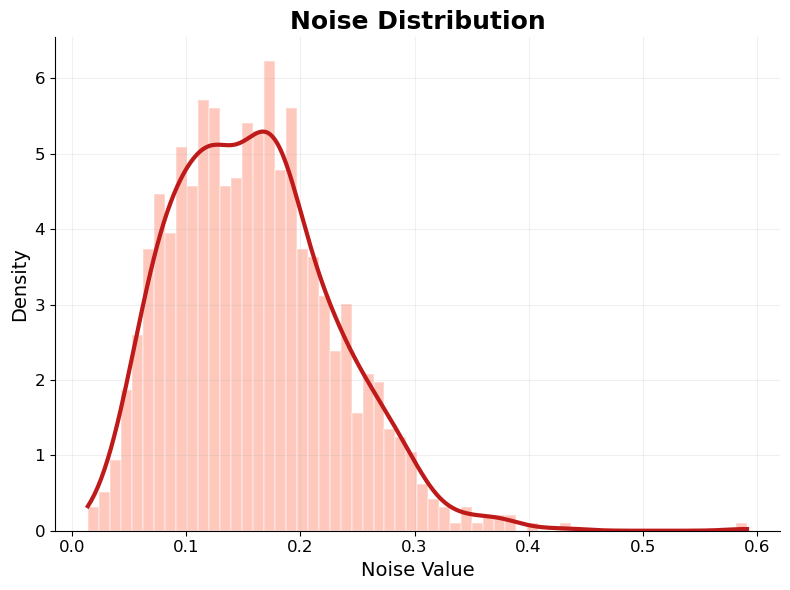

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

def beautiful_noise_plot(noises, title="Noise Distribution"):
    noises = np.array(noises).flatten()
    kde = gaussian_kde(noises)
    
    xs = np.linspace(noises.min(), noises.max(), 400)
    ys = kde(xs)

    plt.figure(figsize=(8,6))
    
    # histogram
    plt.hist(
        noises, bins=60, density=True, alpha=0.35,
        color="#FE6244", edgecolor="white", linewidth=1.2
    )
    
    # KDE curve
    plt.plot(xs, ys, color="#BF1A1A", linewidth=3)

    # Aesthetic improvements
    plt.grid(alpha=0.18)
    plt.title(title, fontsize=18, weight="bold")
    plt.xlabel("Noise Value", fontsize=14)
    plt.ylabel("Density", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Remove top/right borders
    for spine in ["top", "right"]:
        plt.gca().spines[spine].set_visible(False)

    plt.tight_layout()
    plt.show()

# Example
beautiful_noise_plot(noise_rates) 